In [1]:
from jax import jit, vmap
import jax.numpy as jnp
from pybullet_suite import *

pybullet build time: Dec 14 2022 00:46:04


In [2]:
import jax
import os
from pathlib import Path
import trimesh
import open3d as o3d
import kinjax

In [3]:
# robot config
urdf = "panda.urdf"
ee_link_name = "panda_grasptarget"
world = BulletWorld(gui=False)
panda = world.load_robot(Panda, "panda")
lb, ub = panda.joint_lower_limit, panda.joint_upper_limit
dof = 7
link_dict, joint_dict = kinjax.get_link_joint_dict(urdf)
# fk = kinjax.get_FK_fn(link_dict, joint_dict, dof, ee_link_name)
# jac = get_jacobian_fn(link_dict, joint_dict, dof, ee_link_name)

argv[0]=
Robot name: panda


In [4]:
def get_T_offset_lists(
    link_dict: dict, joint_dict: dict, ee_link_name: str
):
    def get_tf_mat(rpy=[0,0,0], trans=[0,0,0]):
        rot_mat = Rotation.from_euler("zyx", rpy[::-1]).as_matrix()
        rot_mat[np.abs(rot_mat) < 1e-9] = 0.
        T = np.block([[rot_mat, np.array(trans)[:,None]], [0,0,0,1]])
        return T
    T_offset_list = []
    
    # Compute the transformation matrices between the base link and the end effector link
    link_name = ee_link_name 
    while True:
        if "parent_joint" not in link_dict[link_name]:  
            break
        parent_joint_name = link_dict[link_name]["parent_joint"]
        parent_joint = joint_dict[parent_joint_name]
        T = get_tf_mat(parent_joint["origin_rpy"], parent_joint["origin_xyz"])
        T_offset_list.append(T)
        link_name = joint_dict[parent_joint_name]["parent"]
    T_offset_list = T_offset_list[::-1]
    return T_offset_list

In [63]:
@jax.jit
def FK(q, T_offsets):
    def yaw_rot_mat(q):
        s, c = jnp.sin(q), jnp.cos(q)
        mat = jnp.array([[c, -s],[s, c]])
        T = jnp.block([[mat, jnp.zeros((2,2))],
                    [jnp.zeros((2,2)), jnp.eye(2)]])
        return T
    
    T = jnp.eye(4) #base link
    Ts = jnp.zeros((1+len(T_offsets), 4, 4))
    Ts = Ts.at[0, :, :].set(T)
    
    for i in range(7):
        T_joint = yaw_rot_mat(q[i])
        T = T @ T_offsets[i] @ T_joint
        Ts = Ts.at[i+1,:,:].set(T)

    for i in range(7, len(T_offsets)):
        T = T @ T_offsets[i]
        Ts = Ts.at[i+1, :, :].set(T)
    return jnp.array(Ts)

In [64]:
T_offsets = get_T_offset_lists(link_dict, joint_dict, "panda_grasptarget")

In [8]:
mesh_path = Path(PANDA_URDF).parent / "meshes/collision"
meshes = os.listdir(mesh_path)

In [224]:
link_names = ["link0.obj", "link1.obj", "link2.obj", "link3.obj", "link4.obj", "link5.obj", "link6.obj", "link7.obj", "hand.obj"]
link_meshes = [trimesh.load(mesh_path/name) for name in link_names]
link_meshes = [mesh if isinstance(mesh, trimesh.Trimesh) else mesh.dump().sum() for mesh in link_meshes]
link_meshes_o3d = [mesh.as_open3d for mesh in link_meshes ]
for mesh in link_meshes_o3d:
    mesh.compute_vertex_normals()
    
T_list = FK(jnp.zeros(7), T_offsets)
for i, mesh in enumerate(link_meshes_o3d):
    mesh.transform(T_list[i])

concatenating texture: may result in visual artifacts


In [67]:
#frame = o3d.geometry.TriangleMesh.create_coordinate_frame(0.1)
o3d.visualization.draw([mesh for mesh in link_meshes_o3d])

In [338]:
class SDF:
    def __init__(self, mesh, pad=8):
        self.mesh = mesh
        self.resolution = 0.01
        self.scale = self.mesh.bounding_box.primitive.extents.max()
        self.center = self.mesh.bounding_box.primitive.transform[:3, -1]
        self.extents = self.mesh.bounding_box.primitive.extents
        self.dim = np.ceil(self.scale/self.resolution).astype(int) + pad
        self.ub = self.idx_to_xyz(np.ones(3) * (self.dim-1))
        self.lb = self.idx_to_xyz(np.zeros(3))
    
    def get_meshgrid_points(self):
        xx = yy = zz = range(self.dim)
        X, Y, Z = np.meshgrid(xx, yy, zz, indexing="ij")
        idx = np.vstack([X.flatten(), Y.flatten(), Z.flatten()]).T
        xyz = (idx - (self.dim-1)/2) * self.resolution + self.center
        return xyz
    
    def gen_sdf_grid(self):
        xyz = self.get_meshgrid_points()
        d = - self.mesh.nearest.signed_distance(xyz) # our convention
        self.D = jnp.array(d.reshape(self.dim, self.dim, -1))
    
    def idx_to_xyz(self, idx):
        return (idx - (self.dim - 1) / 2) * self.resolution + self.center
    
    def xyz_to_idx(self, xyz):
        return (xyz - self.lb) / self.resolution

    def get_sd(self, point, obj_pose):
        p_obj = apply_transform(Tinv(obj_pose), point)
        if not (self.lb < p_obj).all() & (p_obj < self.ub).all() : 
            return jnp.inf
        return interpolate(self.xyz_to_idx(p_obj), self.D)

@jax.jit
def Tinv(pose):
    T = jnp.eye(4)
    R, t = pose[:3, :3], pose[:3, -1]
    T = T.at[:3, :3].set(R.T)
    T = T.at[:3, -1].set(-R.T@t)
    return T

@jax.jit
def apply_transform(T, p):
    return T[:3, :3] @ p + T[:3, -1]

@jax.jit
def interpolate(idx_float, grid):
    (xd, yd, zd), whole = jnp.modf(idx_float)
    x0, y0, z0 = whole.astype(int)
    x1, y1, z1 = x0+1, y0+1, z0+1

    # Interpolate along x
    c00 = grid[x0, y0, z0] * (1 - xd) + grid[x1, y0, z0] * xd
    c01 = grid[x0, y0, z1] * (1 - xd) + grid[x1, y0, z1] * xd
    c10 = grid[x0, y1, z0] * (1 - xd) + grid[x1, y1, z0] * xd
    c11 = grid[x0, y1, z1] * (1 - xd) + grid[x1, y1, z1] * xd

    # Interpolate along y
    c0 = c00 * (1 - yd) + c10 * yd
    c1 = c01 * (1 - yd) + c11 * yd

    # Interpolate along z
    return c0 * (1 - zd) + c1 * zd

interpolate_batch = jax.vmap(interpolate)

In [247]:
link_sdfs = [SDF(link_mesh, interpolate) for link_mesh in link_meshes[:2]]
for link_sdf in link_sdfs:
    link_sdf.gen_sdf()

In [375]:
np.save("check.npy", np.array(link_sdf.D))

In [288]:
%timeit interpolate(jnp.array([2.1, 3.2, 4.3]), sdf.D)

321 µs ± 46.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [296]:
sdf = SDF(link_meshes[0])
sdf.gen_sdf_grid()

In [341]:
point = jnp.array([-0.1,0.1,0.2])
T = T_list[0]

In [348]:
%timeit apply_transform(Tinv(T_list[0]), point)

1.01 ms ± 59.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [360]:
T_list_np = np.array(T_list)

In [369]:
%timeit T_list_np[0].sum()

3.35 µs ± 471 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [370]:
@jax.jit
def indexing(T_list):
    return T_list[0].sum()

In [371]:
%timeit indexing(T_list).block_until_ready()

7.1 µs ± 163 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [295]:
%timeit sdf.get_sd(point, T_list[0])

1.2 ms ± 82.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [270]:
[sdf.get_sd(point, T) for T, sdf in zip(T_list, link_sdfs)]

[Array(0.10517403, dtype=float32), Array(0.08644685, dtype=float32)]

In [220]:
T = jnp.array(T_list[0])
d = sdf.get_sd(point, T)
print(f"d:{d}")

d:None


In [254]:
- link_meshes[1].copy().apply_transform(T_list[1]).nearest.signed_distance(point[None,:])

array([0.12002622])

In [251]:

- link_meshes[1].nearest.signed_distance(point[None, :])

array([0.37154992])

In [269]:
pc = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(sdf.get_meshgrid_points()))
frame = o3d.geometry.TriangleMesh.create_coordinate_frame(0.15)
frame.translate(sdf.center)
sphere = o3d.geometry.TriangleMesh.create_sphere(0.002)
sphere.translate(point)
o3d.visualization.draw([pc, link_meshes_o3d[0], link_meshes_o3d[1], frame, sphere])

In [477]:
R, t = T[:3, :3], T[:3, -1]
Tinv = jnp.block([[R.T, -R.T @ t[:,None]],[jnp.zeros(3), 1]])
p_obj = (Tinv @ jnp.hstack([point, 1])[:,None])[:3].flatten()

In [480]:
frame = o3d.geometry.TriangleMesh.create_coordinate_frame(0.1)
sphere = o3d.geometry.TriangleMesh.create_sphere(0.01)
sphere.translate(p_obj)
mesh_o3d.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh_o3d, frame, sphere])

In [388]:
xx = jnp.linspace(sdf.lb[0], sdf.ub[0], 1000)
yy = jnp.linspace(sdf.lb[1], sdf.ub[1], 1000)
z = -0.3
X, Y = jnp.meshgrid(xx, yy)
points = jnp.hstack([X.reshape(-1, 1), Y.reshape(-1, 1), z*jnp.ones_like(Y.reshape(-1, 1))])
D = interpolate_batch(points).reshape(1000, -1)

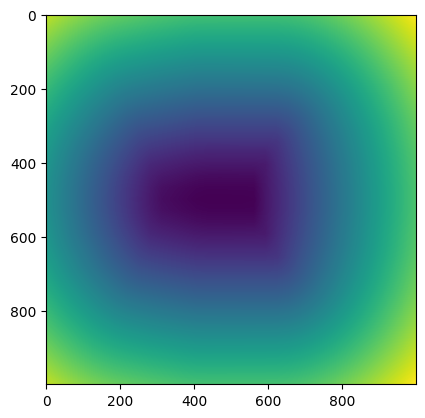

In [389]:
import matplotlib.pyplot as plt
plt.imshow(D)

In [335]:
xx

array([-0.1599129 , -0.15668058, -0.15344825, -0.15021593, -0.14698361,
       -0.14375128, -0.14051896, -0.13728664, -0.13405431, -0.13082199,
       -0.12758967, -0.12435734, -0.12112502, -0.1178927 , -0.11466037,
       -0.11142805, -0.10819573, -0.10496341, -0.10173108, -0.09849876,
       -0.09526644, -0.09203411, -0.08880179, -0.08556947, -0.08233714,
       -0.07910482, -0.0758725 , -0.07264017, -0.06940785, -0.06617553,
       -0.0629432 , -0.05971088, -0.05647856, -0.05324623, -0.05001391,
       -0.04678159, -0.04354926, -0.04031694, -0.03708462, -0.03385229,
       -0.03061997, -0.02738765, -0.02415532, -0.020923  , -0.01769068,
       -0.01445835, -0.01122603, -0.00799371, -0.00476138, -0.00152906,
        0.00170326,  0.00493558,  0.00816791,  0.01140023,  0.01463255,
        0.01786488,  0.0210972 ,  0.02432952,  0.02756185,  0.03079417,
        0.03402649,  0.03725882,  0.04049114,  0.04372346,  0.04695579,
        0.05018811,  0.05342043,  0.05665276,  0.05988508,  0.06

In [285]:
x = np.array([0.0001,0,0])

-0.01775656664796271

In [322]:
sdf.D[tuple(sdf.xyz_to_idx(x).astype(int))]

-0.024856344465293796

In [260]:
sdf.ub

TrackedArray([0.1600871 , 0.12290965, 0.09148455])

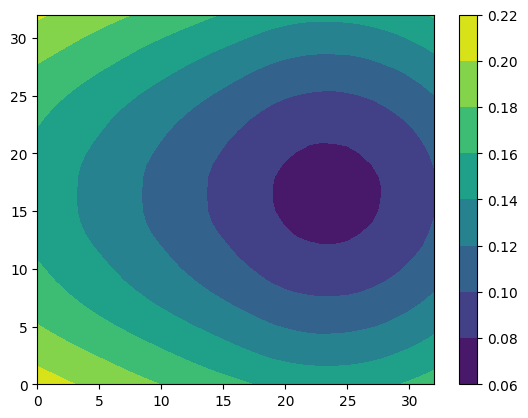

In [208]:
import matplotlib.pyplot as plt
plt.contourf(sdf.D[0])
plt.colorbar()

In [ ]:
pc_grid = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(xyz))

In [174]:
o3d.visualization.draw_geometries([pc_grid, mesh_o3d])

In [133]:
mesh.vertices.max(axis=0)

TrackedArray([0.0551612, 0.0551923, 0.0549731])

In [129]:
center + extents/2

TrackedArray([0.0551612, 0.0551923, 0.0549731])

In [106]:
mesh.vertices.min(axis=0)

TrackedArray([-0.054987, -0.129373, -0.192004])

In [78]:
sm.remove_frame('link1')

In [79]:
sm.view_frame(panda.get_link_pose(0), 'link1', length=1)

In [72]:
pc_mesh.paint_uniform_color([0,0,0])
origin = np.array([-1,1,-1])  #np.array([0,0,0]) 

direction = np.asarray(pc_mesh.points)[idx[0]] - origin
np.asarray(pc_mesh.colors)[idx[0], :] = [1,0,0]

In [96]:
np.asarray(mesh_o3d.vertices).min(axis=0)

array([-0.054987, -0.129373, -0.192004])

In [73]:
mesh.ray.intersects_location(ray_origins=origin[None,:], ray_directions=direction[None,:])

(array([[ 0.05139552, -0.04473941, -0.11913372],
        [-0.03557714,  0.04168265, -0.192     ]]),
 array([0, 0]),
 array([ 58, 292]))

In [80]:
axis = o3d.geometry.TriangleMesh.create_coordinate_frame(0.1)
o3d.visualization.draw_geometries([pc_mesh, axis])